# 02 - Latent Semantic Analysis (LSA)
This notebook performs Latent Semantic Analysis on the governance data set. It assumes the data was cleaned and placed in the cache by the "Explore the Governance Data Set" notebook.

We start out by replicating the steps that Joshua Cook shows in his [Introduction to Latent Semantic Analysis](https://www.youtube.com/playlist?list=PLroeQp1c-t3qwyrsq66tBxfR6iX6kSslt) youtube series. Although we follow his examples, we renamed a few things, graphed some of it and wrap results in a Pandas data frame for readability and easy handling. From there we apply the same to out governance data set. It starts off pretty similar to our earlier notebook that performs a TF-IDF analysis of the documents.

---
## Dependencies and Imports
Here we import the libraries we need to perform our analysis.

In [6]:
!pip install scikit-learn pandas seaborn graphviz

In [7]:
import re
import sys
from pathlib import Path
print("python=={}".format(re.sub(r'\s.*', '', sys.version)))

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import __version__ as sklearn__version__
print(f"scikit-learn=={sklearn__version__}")

import pandas as pd
print(f"pandas=={pd.__version__}")
ROW    = 0
COLUMN = 1
STRING = 'string'
OBJECT = 'object'
NUMBER = 'number'
CATEGORY = 'category'
INTEGER = 'integer'
UNSIGNED = 'unsigned'
FLOAT = 'float'

import matplotlib.pyplot as plt
from matplotlib import __version__ as matplotlib__version__
print(f"matplotlib=={matplotlib__version__}")

import seaborn as sns
CMAP_VLAG = sns.color_palette("vlag", as_cmap=True)
print(f"seaborn=={sns.__version__}")

from graphviz import __version__ as graphviz__version__
print(f"graphviz=={graphviz__version__}")
from graphviz import Source as dot_graph


python==3.9.13
scikit-learn==1.0.2
pandas==1.4.4
matplotlib==3.5.2
seaborn==0.11.2
graphviz==0.20.1


---
## Replicate Joshua Cook's Examples
Joshua starts with a trivial set of documents, represented here by strings in a Pandas data frame.

It may seem a bit odd to use the text as both the index and the body of the data frame. This will become clear below when we need to know what term came from what document.

In [8]:
trivial_body = [
    "the quick brown fox",
    "the slow brown dog",
    "the quick red dog",
    "the lazy yellow fox"
]

trivial_corpus = pd.DataFrame(data=trivial_body, index=trivial_body, columns=["body"])
trivial_corpus

,body
the quick brown fox,the quick brown fox
the slow brown dog,the slow brown dog
the quick red dog,the quick red dog
the lazy yellow fox,the lazy yellow fox


### Document-Term Matrix
Using a count vectorizer he calculates what he calls the document-term matrix. He also uses the term "bag of words", but in this notebook we use the name document-term matrix for precision.

We won't use it on the trivial corpus, but I added the `min_df` parameter for use with the governance data set, later on. That parameter helped a lot to get better results and I expect we will use it again.

Below is a schematic view of the step we are about to take.

In [9]:
dot_graph('''
digraph {
  rankdir=LR;
  node [fontname="georgia; serif" fontsize=9, margin=0 arrowhead=normal arrowtail=dot];
  edge [arrowsize=0.75]

  node [shape=folder]; documents;
  node [shape=oval]; vec [label="count vectorizer"];
  node [shape=plain]; min_df [label="min_df=1"]; dot0 [label=" "];
  node [shape=box]; dtm [label="document term matrix"]; dict [label="dictionary"];

  documents -> corpus;
  min_df -> vec;
  corpus -> vec;
  vec -> dtm;
  vec -> dict;
  dtm -> dot0 [color=grey style=dotted arrowhead=none arrowsize=0.5];
  dict -> dot0 [color=grey style=dotted arrowhead=none arrowsize=0.5];
}
''')


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [10]:
# the caller is expected to select the right column from their data frame and
# pass it in as a series.
def compose_document_term_matrix_by_count(series, min_df=1):
    vectorizer = CountVectorizer(min_df=min_df)
    dt_matrix  = vectorizer.fit_transform(series)
    dictionary = vectorizer.get_feature_names_out()

    return pd.DataFrame(index=series.index, columns=dictionary, data=dt_matrix.toarray()), \
           dictionary


In [11]:
trivial_document_term_matrix, trivial_dictionary = compose_document_term_matrix_by_count(trivial_corpus['body'])
trivial_document_term_matrix


,brown,dog,fox,lazy,quick,red,slow,the,yellow
the quick brown fox,1,0,1,0,1,0,0,1,0
the slow brown dog,1,1,0,0,0,0,1,1,0
the quick red dog,0,1,0,0,1,1,0,1,0
the lazy yellow fox,0,0,1,1,0,0,0,1,1


### Singular Value Decomposition (SVD)
Singular value decomposition (SVD) encodes our corpus into topic encoded data. Instead of feeding it our text corpus, SVD relies on the document-term matrix produced by the count vectorizer above. We use the text corpus only as index so the resulting Pandas data frame is readable. The algorithm relies on the document-term matrix alone.

To make it easier to determine what a topic is about, the LSA function below also returns a encoding matrix based on the dictionary from the count vectorizer.

Using the same, trivial corpus nicely shows a distinction between the documents talking about dogs (shown as "topic 0") and foxes (as "topic 1").


In [12]:
dot_graph('''
digraph {
  rankdir=LR;
  node [fontname="georgia; serif" fontsize=9, margin=0 arrowhead=normal arrowtail=dot];
  edge [arrowsize=0.75]

  node [shape=plain label=" "]; dot0; dot1;
  node [shape=oval]; vec [label="count vectorizer"]; svd [label="singular value decomposition"];
  node [shape=box]; dtm [label="document term matrix"]; dict [label="dictionary"]; topic_enc [label="topic encodings"];
    enc_mtx [label="encoding matrix"];

  dot0 -> vec [color=grey style=dotted arrowhead=vee arrowsize=0.5];
  dot1 -> vec [color=grey style=dotted arrowhead=vee arrowsize=0.5];
  vec -> dtm;
  vec -> dict;
  dtm -> svd;
  dict -> svd;
  svd -> topic_enc;
  svd -> enc_mtx;
}
''')


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [13]:
def perform_lsa(dt_matrix, dictionary, n_components=2):
    svd = TruncatedSVD(n_components=n_components)
    lsa = svd.fit_transform(dt_matrix)
    topics = [f"topic {n}" for n in range(lsa.shape[1])]

    return pd.DataFrame(index=dt_matrix.index, data=lsa, columns=topics), \
           pd.DataFrame(index=topics, data=svd.components_, columns=dictionary).T


In [14]:
trivial_topic_encodings, trivial_encoding_matrix = perform_lsa(trivial_document_term_matrix, trivial_dictionary)
trivial_topic_encodings


,topic 0,topic 1
the quick brown fox,1.694905,0.299524
the slow brown dog,1.515851,-0.769110
the quick red dog,1.515851,-0.769110
the lazy yellow fox,1.266186,1.440585


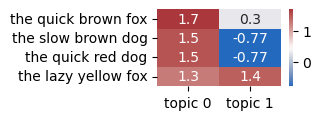

In [15]:
plt.figure(figsize=(2, 1))
sns.heatmap(trivial_topic_encodings, annot=True, cmap=CMAP_VLAG);


In [16]:
trivial_encoding_matrix


,topic 0,topic 1
brown,0.353937,-0.140256
dog,0.334199,-0.459436
fox,0.326416,0.519736
lazy,0.139578,0.430274
quick,0.353937,-0.140256
red,0.167100,-0.229718
slow,0.167100,-0.229718
the,0.660615,0.060300
yellow,0.139578,0.430274


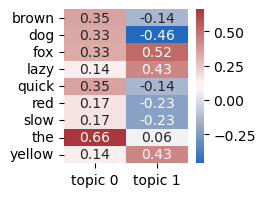

In [17]:
plt.figure(figsize=(2, 2))
sns.heatmap(trivial_encoding_matrix, annot=True, cmap=CMAP_VLAG);


In his code, Joshua takes the absolute values of the topic columns. In his presentation he suggests that we should be looking for the strongest correlations, either negative or positive. Instead of adding columns, we take the absolute value on the fly as we search for the $n$ most significant terms. We don't preserve the absolute values, since they are not needed after selection.

Based on the heatmap above, "topic 1" seems to be based around the type of animal. It has a strong correlation with "fox" and a strong negative correlation with "dog". This is further supported by selecting the most significant terms as shown below.

The stop words are still present. We don't worry about them as they will have been stripped in the data cleaning process of the governance data set.

In [18]:
def n_most_significant(topic, n_terms, encoding_matrix):
    df = encoding_matrix[topic]
    return df.iloc[df.abs().argsort()][::-1][:n_terms].to_frame()

In [19]:
n_most_significant("topic 0", 3, trivial_encoding_matrix)

,topic 0
the,0.660615
brown,0.353937
quick,0.353937


In [20]:
n_most_significant("topic 1", 2, trivial_encoding_matrix)

,topic 1
fox,0.519736
dog,-0.459436


**node**: The scatter plot that Joshua makes relies on the user-supplied classification of the documents. This is an example of supervised input as part of the data validation. Our product owner also spoke of this. We can start doing that once we are working with the whole corpus and have the document type at hand.

XXX: make this plot...

### Use TF-IDF for Stop Word Elimination
Joshua then swaps out the count vectorizer with a TF-IDF vectorizer. We've explored this vectorizer in our previous notebook on TF-IDF already. The TF-IDF vectorizer is a drop-in replacement of the count vectorizer.

Below is the schematic representation of that step, followed by the code and a quick re-run of the visualisation steps.

In [21]:
dot_graph('''
digraph {
  rankdir=LR;
  node [fontname="georgia; serif" fontsize=9, margin=0 arrowhead=normal arrowtail=dot];
  edge [arrowsize=0.75]

  node [shape=folder]; documents;
  node [shape=oval]; vec [label="count vectorizer", color=grey fontcolor=grey style=dotted];
      tfidf [label="TF-IDF vectorizer"];
  node [shape=plain]; min_df [label="min_df=1"]; sublinear_tf [label="sublinear_tf=False"]; dot0 [label=" "];
  node [shape=box]; dtm [label="document term matrix"]; dict [label="dictionary"];

  documents -> corpus;
  corpus -> vec [color=grey style=dotted arrowhead=vee arrowsize=0.5];
  corpus -> tfidf;
  sublinear_tf -> tfidf;
  min_df -> tfidf;
  min_df -> vec [color=grey style=dotted arrowhead=vee arrowsize=0.5];
  vec -> dtm [color=grey style=dotted arrowhead=vee arrowsize=0.5];
  tfidf -> dtm;
  vec -> dict [color=grey style=dotted arrowhead=vee arrowsize=0.5];
  tfidf -> dict;
  dtm -> dot0 [color=grey style=dotted arrowhead=none arrowsize=0.5];
  dict -> dot0 [color=grey style=dotted arrowhead=none arrowsize=0.5];
}
''')

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [22]:
# the caller is expected to select the right column from their data frame and
# pass it in as a series.
def compose_document_term_matrix(series, min_df=1, sublinear_tf=False):
    vectorizer = TfidfVectorizer(min_df=min_df, sublinear_tf=sublinear_tf)
    dt_matrix  = vectorizer.fit_transform(series)
    dictionary = vectorizer.get_feature_names_out()

    return pd.DataFrame(index=series.index, columns=dictionary, data=dt_matrix.toarray()), \
           dictionary


In [23]:
trivial_document_term_matrix, trivial_dictionary = compose_document_term_matrix(trivial_corpus['body'])
trivial_document_term_matrix


,brown,dog,fox,lazy,quick,red,slow,the,yellow
the quick brown fox,0.539313,0.000000,0.539313,0.000000,0.539313,0.000000,0.000000,0.356966,0.000000
the slow brown dog,0.497096,0.497096,0.000000,0.000000,0.000000,0.000000,0.630504,0.329023,0.000000
the quick red dog,0.000000,0.497096,0.000000,0.000000,0.497096,0.630504,0.000000,0.329023,0.000000
the lazy yellow fox,0.000000,0.000000,0.463458,0.587838,0.000000,0.000000,0.000000,0.306758,0.587838


In [24]:
trivial_topic_encodings, trivial_encoding_matrix = perform_lsa(trivial_document_term_matrix, trivial_dictionary)
trivial_topic_encodings


,topic 0,topic 1
the quick brown fox,0.814343,0.163324
the slow brown dog,0.696636,-0.382803
the quick red dog,0.696636,-0.382803
the lazy yellow fox,0.493787,0.810771


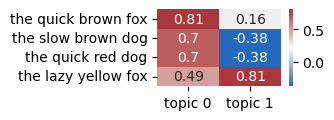

In [25]:
plt.figure(figsize=(2, 1))
sns.heatmap(trivial_topic_encodings, annot=True, cmap=CMAP_VLAG);


---
## Apply LSA to the Governance Data Set
We apply LSA to the subset _duurzaamheidsvisie_ (DV) documents from the governance data set.

### Load the DV Documents from the Governance Data

In [26]:
CACHE_DIR = '../cache/Governance'

GLOB_DV = CACHE_DIR + '/GM????DV??.txt'

# take a glob and make it iterable. We cannot use globs as objects, since these get
# "exhausted" when you iterate over them.
# https://stackoverflow.com/questions/51108256/how-to-take-a-pathname-string-with-wildcards-and-resolve-the-glob-with-pathlib
def expand_glob(glob):
    p = Path(glob)
    return Path(p.parent).expanduser().glob(p.name)

print(f"'Duurzaamheidsvisie' documents = {GLOB_DV}")

DOCUMENT_BODY = 'body'

def load_corpus_as_dataframe(glob):
    df = pd.DataFrame(data   =[file.read_text() for file in expand_glob(glob)],
                      index  =[file.stem        for file in expand_glob(glob)],
                      columns=[DOCUMENT_BODY])
    df[DOCUMENT_BODY] = df[DOCUMENT_BODY].astype(STRING)

    return df


'Duurzaamheidsvisie' documents = ../cache/Governance/GM????DV??.txt


In [27]:
corpus = load_corpus_as_dataframe(GLOB_DV)
corpus


,body
GM0003DV02,duurzaamheidsbeleid Appingedam duurzaamheidsbe...
GM0005DV01,colofon gemeente bedum bezoekadres Schoolstraa...
GM0007DV01,Milieubeleidsplan vaststellen gemeenteraad bel...
GM0009DV01,inhoud duurzaamheidsvisie februari inhoud inho...
GM0034DV01,verseonnr dagmail december raad gemeente almer...
...,...
GM1945DV01,duurzaamheidsprogramma gemeente groesbeek duur...
GM1955DV01,milieuprogramma gemeente Montferland vaststell...
GM1955DV02,notitie ruimtelijk inpassing stroomopwekking z...
GM1955DV03,energietransitienota duurzaam energie achterho...


In [28]:
corpus.info()


<class 'pandas.core.frame.DataFrame'>
Index: 253 entries, GM0003DV02 to GM1987DV01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   body    253 non-null    string
dtypes: string(1)
memory usage: 4.0+ KB


In [29]:
document_term_matrix, dictionary = compose_document_term_matrix(corpus[DOCUMENT_BODY], min_df=20, sublinear_tf=True)
document_term_matrix


,aanbested,aanbesteding,aanbestedingen,aanbestedingsbeleid,aanbeveling,aanbieden,aanbieder,aanbod,aanbrengen,aandacht,...,zowel,zuid,zuinig,zuiveren,zuivering,zullen,zwaar,zwembad,zwerfafval,zwerfvuil
GM0003DV02,0.000000,0.012151,0.000000,0.000000,0.038262,0.030048,0.0,0.012372,0.000000,0.030826,...,0.028764,0.015025,0.032728,0.000000,0.000000,0.038097,0.000000,0.000000,0.000000,0.000000
GM0005DV01,0.000000,0.014400,0.000000,0.000000,0.000000,0.012755,0.0,0.000000,0.018388,0.038480,...,0.026933,0.000000,0.025166,0.000000,0.000000,0.032584,0.000000,0.000000,0.091489,0.000000
GM0007DV01,0.000000,0.000000,0.000000,0.000000,0.000000,0.017514,0.0,0.000000,0.000000,0.017085,...,0.033016,0.000000,0.000000,0.000000,0.000000,0.037543,0.015504,0.000000,0.037267,0.049227
GM0009DV01,0.000000,0.000000,0.000000,0.000000,0.000000,0.017749,0.0,0.034544,0.000000,0.033334,...,0.024318,0.000000,0.000000,0.000000,0.000000,0.042969,0.000000,0.032475,0.000000,0.000000
GM0034DV01,0.000000,0.015250,0.028229,0.000000,0.000000,0.013507,0.0,0.000000,0.000000,0.010631,...,0.030515,0.000000,0.015740,0.000000,0.031714,0.042896,0.034280,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GM1945DV01,0.000000,0.022839,0.017717,0.026661,0.000000,0.014353,0.0,0.000000,0.012221,0.015922,...,0.020209,0.000000,0.016726,0.033302,0.000000,0.023821,0.021514,0.000000,0.000000,0.000000
GM1955DV01,0.000000,0.000000,0.000000,0.000000,0.000000,0.022764,0.0,0.015455,0.000000,0.027612,...,0.018421,0.000000,0.000000,0.000000,0.000000,0.035866,0.048089,0.000000,0.000000,0.000000
GM1955DV02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.024765,0.000000,0.000000,...,0.017434,0.000000,0.025105,0.000000,0.000000,0.026740,0.000000,0.000000,0.000000,0.000000
GM1955DV03,0.000000,0.000000,0.000000,0.000000,0.081858,0.013279,0.0,0.015264,0.000000,0.027272,...,0.029999,0.000000,0.000000,0.000000,0.000000,0.025401,0.000000,0.000000,0.000000,0.000000


In [30]:
dictionary

array(['aanbested', 'aanbesteding', 'aanbestedingen', ..., 'zwembad',
       'zwerfafval', 'zwerfvuil'], dtype=object)

In [31]:
topic_encodings, encoding_matrix = perform_lsa(document_term_matrix, dictionary)
topic_encodings


,topic 0,topic 1
GM0003DV02,0.646084,-0.072133
GM0005DV01,0.590640,0.342839
GM0007DV01,0.617312,0.350270
GM0009DV01,0.559767,-0.120436
GM0034DV01,0.560617,-0.041395
...,...,...
GM1945DV01,0.675114,-0.006574
GM1955DV01,0.547646,0.338284
GM1955DV02,0.507538,-0.111246
GM1955DV03,0.583853,-0.089207


In [32]:
encoding_matrix

,topic 0,topic 1
aanbested,0.012085,-0.008230
aanbesteding,0.021063,0.004095
aanbestedingen,0.007802,-0.000155
aanbestedingsbeleid,0.009714,-0.006076
aanbeveling,0.013303,0.003211
...,...,...
zullen,0.057564,-0.019139
zwaar,0.012786,0.019094
zwembad,0.011229,-0.007004
zwerfafval,0.017096,0.045964


In [33]:
n_most_significant("topic 0", 20, encoding_matrix)

,topic 0
gemeente,0.081739
duurzaam,0.077722
energie,0.067253
maken,0.060878
duurzaamheid,0.060600
bedrijf,0.059290
project,0.058665
zullen,0.057564
gaan,0.057518
jaar,0.057381


In [34]:
n_most_significant("topic 1", 20, encoding_matrix)

,topic 1
gevaarlijk,0.101514
geluid,0.092732
veiligheid,0.087911
melding,0.087095
milieutak,0.082711
bodemkwaliteit,0.080009
omgevingsvergunning,0.079426
milieubeleidsplan,0.077101
wabo,0.076873
milieubeleid,0.076525


### Determine the correct number of topics using latent sementic analysis
Method 1 Explained variance based on https://stackoverflow.com/questions/69091520/determine-the-correct-number-of-topics-using-latent-semantic-analysis

Text(0.5, 1.0, 'explained variance by n-components')

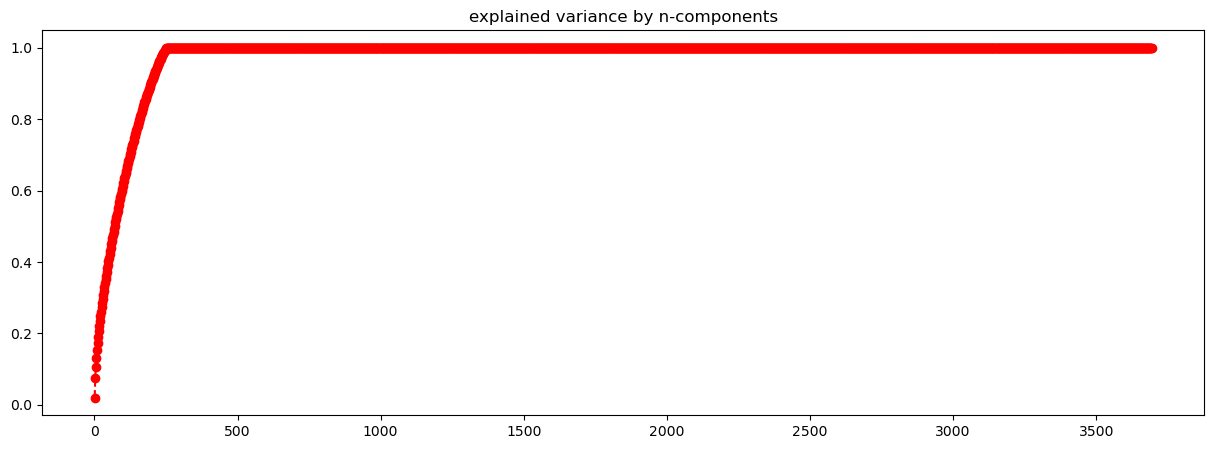

In [38]:
performance = []
test = range(1, document_term_matrix.shape[1], 2)

for n in test:
    svd = TruncatedSVD(n_components=n)
    lsa = svd.fit(document_term_matrix)
    performance.append(lsa.explained_variance_ratio_.sum())

fig = plt.figure(figsize=(15, 5))
plt.plot(test, performance, 'ro--')
plt.title('explained variance by n-components')

Method 2 based on https://www.datacamp.com/tutorial/discovering-hidden-topics-python.
The problem with this method is that it's based on Gensim dictionary where we are using sklearn.